
# Helmet Detection — Faster R-CNN + Custom Head (Own Model)



## 1) Config & Imports
รวมไลบรารีที่ใช้ และกำหนดค่าพื้นฐาน


In [1]:
# !pip install -q albumentations==1.4.10 pycocotools==2.0.8
import os, sys, math, time, random, json, shutil, itertools, warnings
from pathlib import Path
import numpy as np
import torch, torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
torch.__version__, torchvision.__version__


('2.8.0+cu126', '0.23.0+cu126')

In [2]:
from dataclasses import dataclass

@dataclass
class Cfg:
    seed: int = 1337
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_classes: int = 2   # 1 class (helmet) + background
    data_format: str = "VOC"  # "VOC" or "COCO"
    data_root: str = "/content/datasets/helmet"
    img_size: int = 800
    epochs: int = 20
    batch_size: int = 2
    lr: float = 5e-4
    weight_decay: float = 1e-2
    warmup_steps: int = 500
    use_amp: bool = True
    use_ema: bool = True
    ema_decay: float = 0.999
    use_focal: bool = False  # toggle focal loss in custom head

cfg = Cfg()
random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
cfg


Cfg(seed=1337, device='cuda', num_classes=2, data_format='VOC', data_root='/content/datasets/helmet', img_size=800, epochs=20, batch_size=2, lr=0.0005, weight_decay=0.01, warmup_steps=500, use_amp=True, use_ema=True, ema_decay=0.999, use_focal=False)


## 2) Datasets & Transforms & DataLoaders
- นิยามทรานส์ฟอร์ม (รีไซซ์, พลิกภาพ, ปรับสี) และคลาส Dataset ที่อ่านรูป+กล่องจากสไตล์ VOC แล้วคืน (image_tensor, target_dict)

- collate_fn จัดรูปแบบแบตช์ให้เข้ากับโมเดล detection

- สร้าง DataLoader สำหรับ train/val/test กำหนด batch_size, num_workers และออปชันเร่งความเร็ว (pin memory, persistent workers)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import random

DATA_ROOT = Path("/content/drive/MyDrive/helmet_dataset")
CLASSES = ["background","helmet"]   # 0 = bg, 1 = helmet
BATCH_SIZE = 2

# ------------ Transforms (apply to image + target) ------------
def resize_with_boxes(img, target, size=640):
    """Resize สั้นสุดเป็น 'size' พร้อมสเกล bbox ให้ตรงภาพ"""
    w0, h0 = img.size
    img = TF.resize(img, size)  # int => resize short side = size, aspect ratio fixed
    w1, h1 = img.size
    sx, sy = w1 / w0, h1 / h0
    if target["boxes"].numel():
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] *= sx
        boxes[:, [1, 3]] *= sy
        # clamp
        boxes[:, 0::2] = boxes[:, 0::2].clamp(0, w1 - 1)
        boxes[:, 1::2] = boxes[:, 1::2].clamp(0, h1 - 1)
        target["boxes"] = boxes
    return img, target

def hflip_with_boxes(img, target, p=0.5):
    if random.random() >= p:
        return img, target
    w, h = img.size
    img = TF.hflip(img)
    if target["boxes"].numel():
        boxes = target["boxes"].clone()
        x1 = boxes[:, 0].clone()
        x2 = boxes[:, 2].clone()
        boxes[:, 0] = w - 1 - x2
        boxes[:, 2] = w - 1 - x1
        target["boxes"] = boxes
    return img, target

def to_tensor(img, target):
    return TF.to_tensor(img), target

def make_transforms(train=True, size=640):
    def _apply(img, target):
        # Resize ก่อน
        img, target = resize_with_boxes(img, target, size=size)
        # Augmentation เบา ๆ เฉพาะ train
        if train:
            img, target = hflip_with_boxes(img, target, p=0.5)
            # ColorJitter ของ torchvision ทำกับ PIL/เทนเซอร์อย่างเดียว ไม่กระทบ bbox
            img = TF.adjust_brightness(img, 1.0 + (random.random()-0.5)*0.2)
            img = TF.adjust_contrast(img,  1.0 + (random.random()-0.5)*0.2)
            img = TF.adjust_saturation(img,1.0 + (random.random()-0.5)*0.2)
        # ToTensor
        img, target = to_tensor(img, target)
        return img, target
    return _apply

def collate_fn(batch):
    return tuple(zip(*batch))

# ------------ Dataset ------------
class VOCDatasetSimple(torch.utils.data.Dataset):
    def __init__(self, root: Path, split="train", transforms=None, class_map={"helmet":1}, allow_empty=False):
        self.root = Path(root); self.transforms = transforms
        self.class_map = class_map; self.allow_empty = allow_empty
        img_dir = self.root/split/"images"; ann_dir = self.root/split/"annotations"
        assert img_dir.exists() and ann_dir.exists(), f"missing {img_dir} or {ann_dir}"
        exts = {".jpg",".jpeg",".png"}
        imgs = [p for p in img_dir.iterdir() if p.suffix.lower() in exts]
        ann_map = {p.stem: p for p in ann_dir.glob("*.xml")}
        pairs = [(ip,ann_map[ip.stem]) for ip in sorted(imgs) if ip.stem in ann_map]

        keep=[]
        for ip, ap in pairs:
            try:
                r=ET.parse(ap).getroot()
                if any(True for _ in r.iter('object')): keep.append((ip,ap))
            except: pass
        assert keep, "no valid pairs"
        self.pairs = keep

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        img_path, ann_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        W,H = img.size
        r = ET.parse(ann_path).getroot()
        boxes, labels = [], []
        for obj in r.iter('object'):
            name = (obj.find('name').text or "").strip()
            b = obj.find('bndbox');
            if b is None: continue
            x1=float(b.find('xmin').text); y1=float(b.find('ymin').text)
            x2=float(b.find('xmax').text); y2=float(b.find('ymax').text)
            x1,x2 = min(x1,x2), max(x1,x2); y1,y2 = min(y1,y2), max(y1,y2)
            x1 = max(0,min(x1,W-1)); x2 = max(0,min(x2,W-1))
            y1 = max(0,min(y1,H-1)); y2 = max(0,min(y2,H-1))
            if x2>x1 and y2>y1:
                boxes.append([x1,y1,x2,y2]); labels.append(self.class_map.get(name,1))

        # ถ้าไม่มีกล่องและไม่อนุญาต ให้สุ่มหยิบตัวอื่นแทน (ป้องกัน crash)
        if not boxes and not self.allow_empty:
            return self.__getitem__((idx+1)%len(self))

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
        }

        if self.transforms:
            img, target = self.transforms(img, target)
        else:
            img = TF.to_tensor(img)
        return img, target

# ------------ Build datasets ------------
train_ds = VOCDatasetSimple(DATA_ROOT, "train", make_transforms(True,  size=640))
val_ds   = VOCDatasetSimple(DATA_ROOT, "val",   make_transforms(False, size=640))
test_ds  = VOCDatasetSimple(DATA_ROOT, "test",  make_transforms(False, size=640))

# ------------ DataLoaders (Colab-friendly) ------------
# ถ้ามี error กับ persistent_workers ในโน้ตบุ๊กที่รันครั้งแรก ให้ตั้งเป็น False
num_workers = 2
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=num_workers, pin_memory=True, prefetch_factor=2,
    persistent_workers=True, collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False,
    num_workers=num_workers, pin_memory=True, prefetch_factor=2,
    persistent_workers=True, collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False,
    num_workers=num_workers, pin_memory=True, prefetch_factor=2,
    persistent_workers=True, collate_fn=collate_fn,
)

# ช่วยให้ cudnn เลือก kernel ที่เหมาะเมื่อขนาดภาพคงที่
torch.backends.cudnn.benchmark = True

print("sizes:", len(train_ds), len(val_ds), len(test_ds))


sizes: 4000 500 500



## 3) Models
### 3.1 Baseline — Faster R-CNN (ResNet50-FPN)
### 3.2 **HelmetRCNN-Plus (Own Head)**
replace `FastRCNNPredictor` with a custom MLP head:
- 1024 → LayerNorm → SiLU → Dropout(0.3) → 1024 → SiLU



In [5]:
# =========================
# Imports & Device
# =========================
import math, time, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# ตรวจสอบให้แน่ใจว่ามี train_loader, test_loader ที่คืน ([image_tensors], [targets_dicts])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# =========================
# Model Head (Custom Fast R-CNN Predictor)
# =========================
class CustomFastRCNNPredictor(nn.Module):
    """
    แทนที่ head เดิมของ Faster R-CNN ด้วย MLP + SiLU + LayerNorm
    หมายเหตุ: num_classes ต้อง "รวม background class" ด้วยตามสไตล์ torchvision
    """
    def __init__(self, in_channels, num_classes):
        super().__init__()
        hidden = 1024
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden),
            nn.LayerNorm(hidden),
            nn.SiLU(),
            nn.Dropout(0.30),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
        )
        self.cls_score = nn.Linear(hidden, num_classes)
        self.bbox_pred = nn.Linear(hidden, num_classes * 4)

    def forward(self, x):
        x = self.mlp(x)
        return self.cls_score(x), self.bbox_pred(x)


# 4) Training Loop (+ Plot)

In [8]:
# ==== 1) LR schedule: Warmup + Cosine with floor ====
def warmup_cosine(step, warmup, total_steps, eta_min=1e-5):
    if total_steps <= 0:
        return 1.0
    if step < warmup:
        return step / max(1, warmup)
    p = (step - warmup) / max(1, total_steps - warmup)
    scale = 0.5 * (1 + math.cos(math.pi * p))
    # floor ไว้ที่ eta_min (เป็นสัดส่วนของ base_lr)
    return eta_min + (1 - eta_min) * scale


def get_model(num_classes: int = 2, fast=True, score_thresh=0.05,
              min_size=640, max_size=640,  # รีไซส์เล็กลง = ไวขึ้น
              ):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(
        weights=weights,
        box_score_thresh=score_thresh,
        min_size=min_size,   # ↓ ความละเอียดอินพุต
        max_size=max_size,
    )

    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = CustomFastRCNNPredictor(in_feats, num_classes)

    # ปรับลด proposal ให้เบาลง
    if fast:
        model.rpn.pre_nms_top_n_train = 256
        model.rpn.post_nms_top_n_train = 128
        model.rpn.pre_nms_top_n_test  = 256
        model.rpn.post_nms_top_n_test = 128
        model.roi_heads.batch_size_per_image = 64  # เดิม 128

    return model

# ==== Validation loss (run in train() but no grad) ====
def eval_epoch_loss(model, loader, device, max_steps=None):
    """
    คำนวณ average validation loss สำหรับ Faster R-CNN
    หมายเหตุ: ต้องใช้ model.train() ร่วมกับ torch.no_grad()
    เพราะ FasterRCNN จะ 'คืนค่า loss' เฉพาะในโหมด train และเมื่อส่ง targets เข้าไป
    """
    was_training = model.training
    model.train()  # ให้ forward แบบคำนวณ loss
    n, total = 0, 0.0
    with torch.no_grad():
        for i, (images, targets) in enumerate(loader):
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)   # dict of losses
            loss = sum(loss_dict.values())       # total loss
            total += float(loss.item())
            n += 1

            if max_steps is not None and n >= max_steps:
                break

    if not was_training:
        model.eval()
    return total / max(n, 1)


# ==== 3) ใช้ val_loader สำหรับ validation loss ====
def train_and_plot(
    train_loader,
    val_loader,              # <<-- เปลี่ยนชื่อเป็น val_loader
    num_classes=2,
    epochs=10,
    base_lr=7e-4,
    weight_decay=1e-2,
    use_amp=True,
    warmup_steps=300,
    max_steps_per_epoch=300,
    score_thresh=0.05,
    fast_model=True,
    min_size=800, max_size=800,
    eta_min=1e-5
):
    model = get_model(num_classes=num_classes, fast=fast_model,
                      score_thresh=score_thresh, min_size=min_size, max_size=max_size).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scaler = GradScaler(enabled=use_amp)

    steps_per_epoch = len(train_loader) if max_steps_per_epoch is None else max_steps_per_epoch
    total_steps = epochs * steps_per_epoch

    history = {"train_loss": [], "val_loss": []}
    global_step = 0

    plt.figure(figsize=(6, 4))
    for ep in range(1, epochs + 1):
        model.train()
        batch_losses = []
        start_t = time.time()

        for i, (images, targets) in enumerate(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast(enabled=use_amp):
                loss_dict = model(images, targets)
                loss = sum(loss_dict.values())

            lr_scale = warmup_cosine(global_step, warmup_steps, total_steps, eta_min=eta_min)
            for pg in optimizer.param_groups:
                pg["lr"] = base_lr * lr_scale

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_losses.append(loss.item())
            global_step += 1
            if max_steps_per_epoch and (i + 1) >= max_steps_per_epoch:
                break

        train_epoch_loss = float(np.mean(batch_losses)) if batch_losses else float('nan')
        val_epoch_loss   = eval_epoch_loss(model, val_loader, device,
                                           max_steps=(max_steps_per_epoch or None))
        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)

        # live plot
        clear_output(wait=True)
        plt.clf()
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"],   label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title(f"Train vs Val Loss (Epoch {ep}/{epochs})")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

        elapsed = time.time() - start_t
        print(f"Epoch {ep:02d}/{epochs} | train={train_epoch_loss:.4f} | val={val_epoch_loss:.4f} "
              f"| lr={optimizer.param_groups[0]['lr']:.2e} | time={elapsed:.1f}s")

    total_params_m = sum(p.numel() for p in model.parameters()) / 1e6
    print(f"Total parameters: {total_params_m:.2f} M")
    return model, history

# ==== 4) Metrics: AP@0.5, Precision, Recall, F1 ====
@torch.no_grad()
def iou_matrix(a, b):
    # a: [Na,4], b: [Nb,4] (x1,y1,x2,y2)
    if a.numel()==0 or b.numel()==0:
        return torch.zeros((a.size(0), b.size(0)), device=a.device)
    tl = torch.maximum(a[:, None, :2], b[None, :, :2])
    br = torch.minimum(a[:, None, 2:], b[None, :, 2:])
    wh = (br - tl).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    union = area_a[:, None] + area_b[None, :] - inter
    return inter / union.clamp(min=1e-6)

@torch.no_grad()
def evaluate_detection(model, loader, device, iou_thr=0.5):
    """
    คืน: AP@0.5 (VOC-style continuous), precision/recall/F1 ที่ threshold ดีสุด (ค้นด้วย score)
    """
    model.eval()
    scores_all, matches_all = [], []
    gt_total = 0

    # เก็บ prediction ทั้งชุด (class=helmet=1 เท่านั้น)
    for images, targets in loader:
        images = [img.to(device) for img in images]
        outs = model(images)

        for out, tgt in zip(outs, targets):
            # เฉพาะคลาส 1
            mask = (out["labels"].to("cpu")==1)
            boxes = out["boxes"][mask].to(device)
            scores = out["scores"][mask].to(device)

            gt = tgt["boxes"].to(device)
            gt_total += gt.size(0)

            # จับคู่ Greedy ตาม score จากมาก→น้อย (กันชนซ้ำ)
            order = torch.argsort(scores, descending=True)
            boxes = boxes[order]; scores = scores[order]
            scores_all.extend(scores.tolist())

            ious = iou_matrix(boxes, gt)
            gt_used = torch.zeros(gt.size(0), dtype=torch.bool, device=device)
            for j in range(boxes.size(0)):
                # หา GT ที่ IoU สูงสุด
                if gt.numel()==0:
                    matches_all.append(0)  # FP
                    continue
                i = torch.argmax(ious[j])
                if ious[j, i] >= iou_thr and not gt_used[i]:
                    matches_all.append(1)  # TP
                    gt_used[i] = True
                else:
                    matches_all.append(0)  # FP

    if len(scores_all)==0:
        return {"AP50": 0.0, "best_thr": 0.5, "precision": 0.0, "recall": 0.0, "f1": 0.0}

    # จัดเรียงตาม score รวมทั้งชุด
    order = np.argsort(-np.array(scores_all))
    matches = np.array(matches_all)[order].astype(np.int32)
    scores_sorted = np.array(scores_all)[order]

    tp = np.cumsum(matches)
    fp = np.cumsum(1 - matches)
    recall = tp / max(gt_total, 1)
    precision = tp / np.maximum(tp + fp, 1)

    # AP (area under P-R)
    # ทำแบบ monotonic precision
    mpre = np.maximum.accumulate(precision[::-1])[::-1]
    # integrate
    ap = np.sum((recall[1:] - recall[:-1]) * mpre[1:])

    # เลือก threshold ที่ให้ F1 สูงสุด
    f1 = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
    k = np.argmax(f1)
    best = {
        "AP50": float(ap),
        "best_thr": float(scores_sorted[k]),
        "precision": float(precision[k]),
        "recall": float(recall[k]),
        "f1": float(f1[k]),
    }
    return best


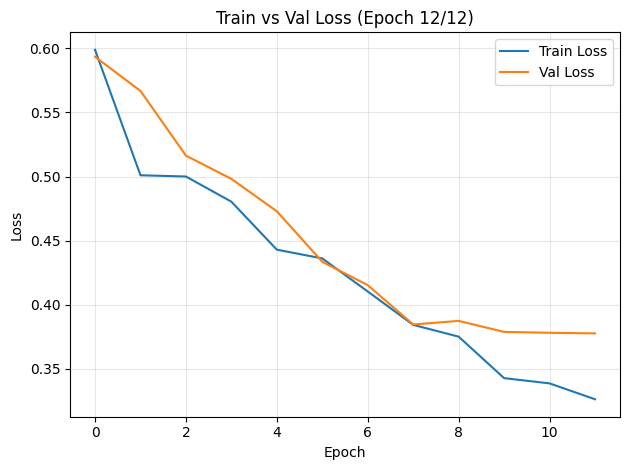

Epoch 12/12 | train=0.3263 | val=0.3777 | lr=7.16e-09 | time=100.4s
Total parameters: 43.40 M
[TEST] AP@0.5=0.893  F1=0.870  P=0.916  R=0.828  (best score thr≈0.820)


In [9]:
num_classes = 2
model, history = train_and_plot(
    train_loader, val_loader,
    num_classes=num_classes,
    epochs=12,
    base_lr=7e-4,
    weight_decay=1e-2,
    use_amp=True,
    warmup_steps=300,
    max_steps_per_epoch=300,
    score_thresh=0.05,
    fast_model=True,
    min_size=800, max_size=800,
    eta_min=1e-5
)

# ประเมินบน test set
metrics = evaluate_detection(model, test_loader, device, iou_thr=0.5)
print(f"[TEST] AP@0.5={metrics['AP50']:.3f}  "
      f"F1={metrics['f1']:.3f}  P={metrics['precision']:.3f}  R={metrics['recall']:.3f}  "
      f"(best score thr≈{metrics['best_thr']:.3f})")



## 5) Qualitative Visualization
วาดผลทำนายบนภาพตัวอย่าง (กล่อง + label + score) เพื่อไล่ดูเคสจริง

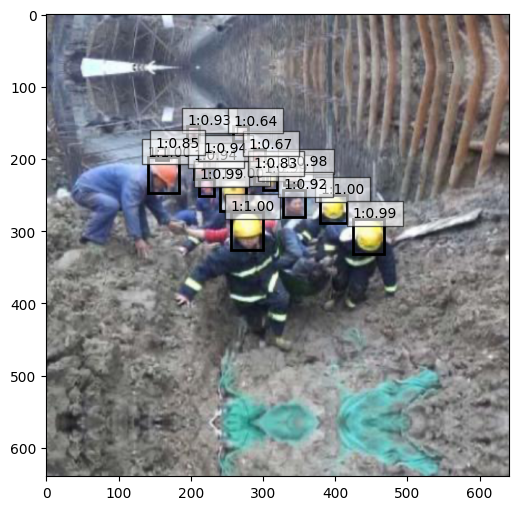

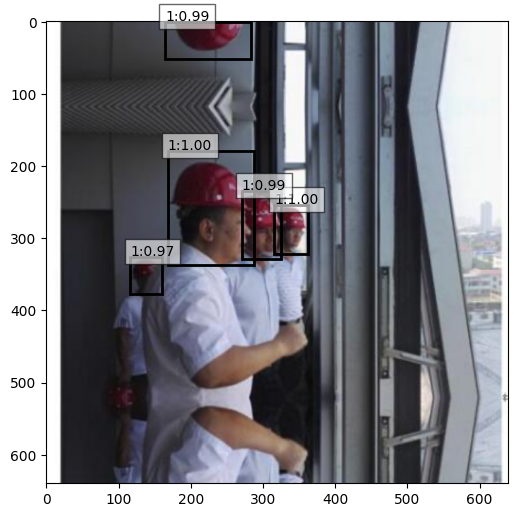

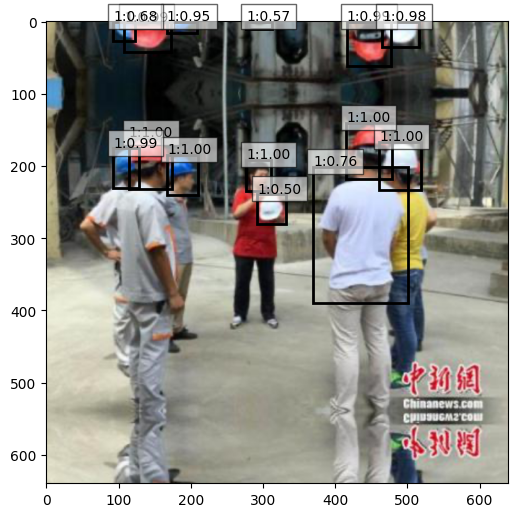

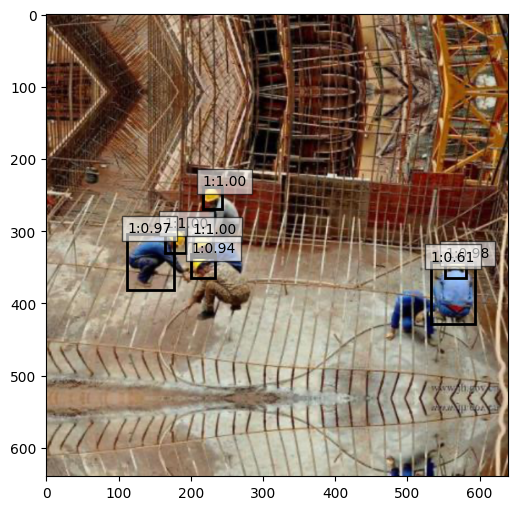

In [15]:
import torchvision.transforms.functional as F
import matplotlib.patches as patches

@torch.no_grad()
def visualize_sample(model, dataset, idx=10, score_thr=0.5):
    model.eval()
    img, target = dataset[idx]
    out = model([img.to(cfg.device)])[0]
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(F.to_pil_image(img))
    for box, score, label in zip(out["boxes"].cpu(), out["scores"].cpu(), out["labels"].cpu()):
        if score < score_thr: continue
        x1,y1,x2,y2 = box.tolist()
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-2, f"{int(label.item())}:{score:.2f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
    plt.show()

visualize_sample(model, val_ds, idx=min(20, len(val_ds)-1), score_thr=0.5)
visualize_sample(model, val_ds, idx=min(0, len(val_ds)-1), score_thr=0.5)
visualize_sample(model, val_ds, idx=min(60, len(val_ds)-1), score_thr=0.5)
visualize_sample(model, val_ds, idx=min(200, len(val_ds)-1), score_thr=0.5)

# 6) Save Model

In [13]:
torch.save(model.state_dict(), "fasterrcnn_helmet.pt")

model.eval()
imgs, tgts = next(iter(test_loader))
with torch.no_grad():
    out = model([img.to(device) for img in imgs])
print({k: v.shape if hasattr(v, 'shape') else len(v) for k,v in out[0].items()})


{'boxes': torch.Size([8, 4]), 'labels': torch.Size([8]), 'scores': torch.Size([8])}
